**Notebook description**: The goal of this notebook is to analyze what similarity measure is the best for clustering the data. The KPI of the measure in this case is it's (negative) correlation with the performance of a model built on a pair of time series. In other words, a good measure will deem time series similar that will result in a good model performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Data preparation

In [2]:
# Load the data
DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/1.Agroknow/data"

df = pd.read_csv(os.path.join(DATADIR, "monthly.csv"), index_col=0)

df.index = pd.to_datetime(df.index)

# Rename the index
df.index.name = "ds"

df

,bovine,cereals and bakery products,chocolate and chocolate products,eggs and egg products,fats and oils,feed additives,fish and fish products,fruits and vegetables,herbs and spices,honey and royal jelly,nuts nut products and seeds,pet feed,poultry meat and poultry meat products
ds,,,,,,,,,,,,,
2000-01-01,1,0,0,1,0,0,3,7,3,0,6,0,0
2000-02-01,0,1,0,0,0,0,5,3,0,0,5,0,0
2000-03-01,2,0,0,0,0,0,9,4,2,0,14,0,0
2000-04-01,1,0,0,1,1,0,3,6,0,0,8,0,3
2000-05-01,0,4,0,0,0,0,9,3,1,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,12,105,31,3,6,5,78,152,83,1,48,6,56
2023-01-01,4,140,22,4,10,2,42,165,69,2,59,3,33
2023-02-01,7,112,12,0,7,1,52,178,60,4,98,4,53


In [3]:
# Split the data into training and test sets

def train_test_split(df, test_perc=0.1):
    m,n = df.shape
    test_size = np.ceil(test_perc*m).astype(int)

    X_train = df.iloc[:-test_size]
    X_test = df.iloc[-test_size:]

    return X_train, X_test

X_train, X_test = train_test_split(df)

test_size = X_test.shape[0]

X_train.shape, X_test.shape

((252, 13), (28, 13))

# Define helper functions

In [4]:
# Define the list of metrics
from scipy.stats import spearmanr, kendalltau

metrics = ['chebyshev', 'cosine', 'matching', 'euclidean', 'braycurtis', 'cityblock',  'jaccard', 'russellrao', 'hamming', 'rogerstanimoto', 'minkowski', 'manhattan', 'correlation', 'yule', 'canberra', 'sokalsneath', 'sokalmichener', 'dice']

metrics = {k: k for k in metrics}

metrics["spearman"] = lambda x,y: spearmanr(x,y)[0]
metrics['kendall'] = lambda x,y: kendalltau(x,y)[0]

metrics.keys()

dict_keys(['chebyshev', 'cosine', 'matching', 'euclidean', 'braycurtis', 'cityblock', 'jaccard', 'russellrao', 'hamming', 'rogerstanimoto', 'minkowski', 'manhattan', 'correlation', 'yule', 'canberra', 'sokalsneath', 'sokalmichener', 'dice', 'spearman', 'kendall'])

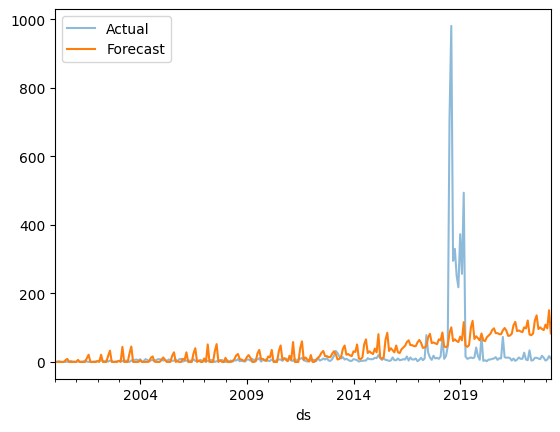

85.4031824432121

In [24]:
# Define helper functions
from sklearn.metrics import pairwise_distances
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error
import logging

logging.getLogger("cmdstanpy").disabled = True #  turn 'cmdstanpy' logs off

def date_range(start, periods, freq='W'):
    if freq == 'W':
        return pd.DatetimeIndex([start + pd.DateOffset(weeks=i) for i in range(1,periods+1)])
    elif freq == 'D':
        return pd.DatetimeIndex([start + pd.DateOffset(days=i) for i in range(1,periods+1)])
    elif freq == 'M':
        return pd.DatetimeIndex([start + pd.DateOffset(months=i) for i in range(1,periods+1)])
    else:
        raise ValueError("Invalid frequency")


def make_future_dataframe(model, periods, freq='W', include_history=False):
    last_date = model.history['ds'].max()
    dates = date_range(last_date, periods, freq)
    dates = dates[dates > last_date]  # Drop start if equals last_date
    dates = dates[:periods]  # Return correct number of periods

    if include_history:
        dates = np.concatenate((np.array(model.history_dates), dates))

    return pd.DataFrame({'ds': dates})

def build_model():
    return Prophet()

def fit_forecast(y, periods, freq='W', include_history=False):
    # Get a very complicated model
    model = Prophet()

    # Prepare for prophet
    y.name = "y"
    y = y.reset_index()

    # Fit the model
    model.fit(y) 

    # Predict
    future = make_future_dataframe(model, periods=periods, freq=freq, include_history=include_history)
    ypred = model.predict(future)
    ypred = model.predict(future)[['ds','yhat']]
    ypred.set_index(ypred.ds, inplace=True)
    ypred = ypred['yhat']

    # Only take the predictions
    # ypred = ypred.iloc[-weeks:]

    # Make things non-negative integers 
    ypred = ypred.round().astype(int)
    ypred[ypred < 0] = 0

    return ypred

def plot_comparison(ytrue, ypred, ax):
    if ax is None:
        fig, ax = plt.subplots()
    ytrue.plot(ax=ax, label="Actual", alpha=0.5)
    ypred.plot(ax=ax, label="Forecast")
    ax.legend()
    return ax

def evaluate(ytrue, ypred, plot=False):
    if plot:
        plot_comparison(ytrue, ypred, None)
        plt.show()
    return root_mean_squared_error(ytrue, ypred)

ypred = fit_forecast(X_train.iloc[:, 0], test_size, freq='M', include_history=True)

evaluate(df.iloc[:, 0], ypred, plot=True)

# Experiment

In [15]:
# Get the RMSEs of all pairwise models
n = X_train.shape[1]
pair_rmse = np.zeros((n,n))
for i in range(n):
    for j in range(i,n):
        ytrain = (X_train.iloc[:,i] + X_train.iloc[:,j]) / 2
        ytest = (X_test.iloc[:,i] + X_test.iloc[:,j]) / 2
        ypred = fit_forecast(ytrain, test_size, freq='M', include_history=False)
        rmse = evaluate(ytest, ypred)
        pair_rmse[i,j] = rmse
        pair_rmse[j,i] = rmse

pair_rmse[:5,:5]

array([[87.76632937, 45.09830532, 47.57972632, 47.81820111, 41.7439046 ],
       [45.09830532, 80.12334242, 59.81451986, 39.00034341, 40.53415667],
       [47.57972632, 59.81451986, 46.04035497, 22.5574663 , 23.64525775],
       [47.81820111, 39.00034341, 22.5574663 ,  5.04267503,  3.23623458],
       [41.7439046 , 40.53415667, 23.64525775,  3.23623458,  3.94153705]])

In [12]:
# Save the results
np.save(os.path.join("output", "pairwise_models_rmse_monthly.npy"), pair_rmse)

In [19]:
# Get all relative errors
rel_errors = pair_rmse / pair_rmse.diagonal()[:, None]
rel_errors[:5,:5]

array([[ 1.        ,  0.51384518,  0.54211822,  0.54483538,  0.4756255 ],
       [ 0.56286101,  1.        ,  0.74653051,  0.48675383,  0.50589698],
       [ 1.03343526,  1.29917591,  1.        ,  0.48994988,  0.51357679],
       [ 9.48270528,  7.73405845,  4.4733135 ,  1.        ,  0.64176941],
       [10.59076805, 10.28384516,  5.99899417,  0.82105903,  1.        ]])

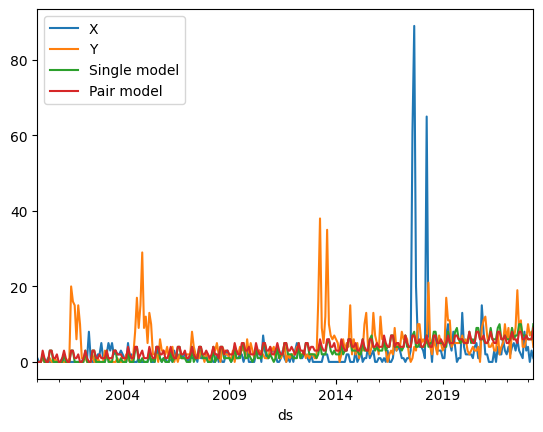

In [34]:
# Plot a model with better performance than the baseline
i,j = 3,4

x,y = df.iloc[:,i], df.iloc[:,j]
xy = (x + y) / 2

xt, yt = X_train.iloc[:,i], X_train.iloc[:,j]
xyt = (xt + yt) / 2

xi, yi = X_test.iloc[:,i], X_test.iloc[:,j]
xyi = (xi + yi) / 2

ypred1 = fit_forecast(xt, test_size, freq='M', include_history=True)
ypred2 = fit_forecast(xyt, test_size, freq='M', include_history=True)

fig, ax = plt.subplots()
x.plot(ax=ax, label="X")
y.plot(ax=ax, label="Y")
ypred1.plot(ax=ax, label="Single model")
ypred2.plot(ax=ax, label="Pair model")

ax.legend()
plt.show()

In [44]:
def flat_triu(matrix):
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, k=1)]

# Get the correlations between the different distance metrics and the paired RMSEs
corrs = {}
rel_errors_flat = flat_triu(rel_errors)
for k, m in metrics.items():
    D = flat_triu(pairwise_distances(df.T.values, metric=m))
    corr = np.corrcoef(D, rel_errors_flat)[0,1]
    corrs[k] = corr

# Print sorted correlations
sorted_corrs = sorted(corrs.items(), key=lambda x: x[1], reverse=True)
sorted_corrs

/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/1.Agroknow/.venv/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2350: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/1.Agroknow/.venv/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2350: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/1.Agroknow/.venv/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2350: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/1.Agroknow/.venv/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2350: DataConversionWarning: Data was converted to boolean for metric yule
  warning

[('canberra', 0.3788610441982873),
 ('cityblock', 0.36958054047719485),
 ('manhattan', 0.36958054047719485),
 ('braycurtis', 0.32411599880416836),
 ('matching', 0.22703213618608076),
 ('hamming', 0.22703213618608076),
 ('euclidean', 0.17051521080635185),
 ('minkowski', 0.17051521080635185),
 ('correlation', 0.12681822545964297),
 ('rogerstanimoto', 0.12568760749928326),
 ('sokalmichener', 0.12568760749928326),
 ('sokalsneath', 0.09743160081051401),
 ('jaccard', 0.062223311463793556),
 ('dice', 0.033281971870141494),
 ('russellrao', 0.023635585417895105),
 ('chebyshev', -0.0954483256780341),
 ('cosine', -0.09841115405811926),
 ('spearman', -0.1144260217219194),
 ('kendall', -0.11906835822341912),
 ('yule', -0.23645565209770586)]

# Misc checks

In [129]:
# See the parameters of a typical Agroknow model 
from model_loader import load_model

MODEL_DIR = os.path.join(DATADIR, 'top-performing-models')

name = "fruits and vegetables"

model = load_model(os.path.join(MODEL_DIR, "top-20-product-models", f"{name}.pkl"))

# print all the parameters of the model
def print_params(model):
    print("changepoint prior scale: ", model.changepoint_prior_scale)
    print("seasonality prior scale: ", model.seasonality_prior_scale)
    print("seasonality mode: ", model.seasonality_mode)
    print("n_change_points: ", model.n_changepoints)
    print("yearly seasonality: ", model.yearly_seasonality)
    print("weekly seasonality: ", model.weekly_seasonality)
    print("daily seasonality: ", model.daily_seasonality)
    print("interval width: ", model.interval_width)
    print('growth: ', model.growth)

print_params(model)

changepoint prior scale:  0.05
seasonality prior scale:  10.0
seasonality mode:  additive
n_change_points:  25
yearly seasonality:  auto
weekly seasonality:  auto
daily seasonality:  auto
interval width:  0.8
growth:  linear


In [130]:
# Check if other models have the same parameters
model = load_model(os.path.join(MODEL_DIR, "top-20-product-models", "fish and fish products.pkl"))
print_params(model)

changepoint prior scale:  0.05
seasonality prior scale:  10.0
seasonality mode:  additive
n_change_points:  25
yearly seasonality:  auto
weekly seasonality:  auto
daily seasonality:  auto
interval width:  0.8
growth:  linear


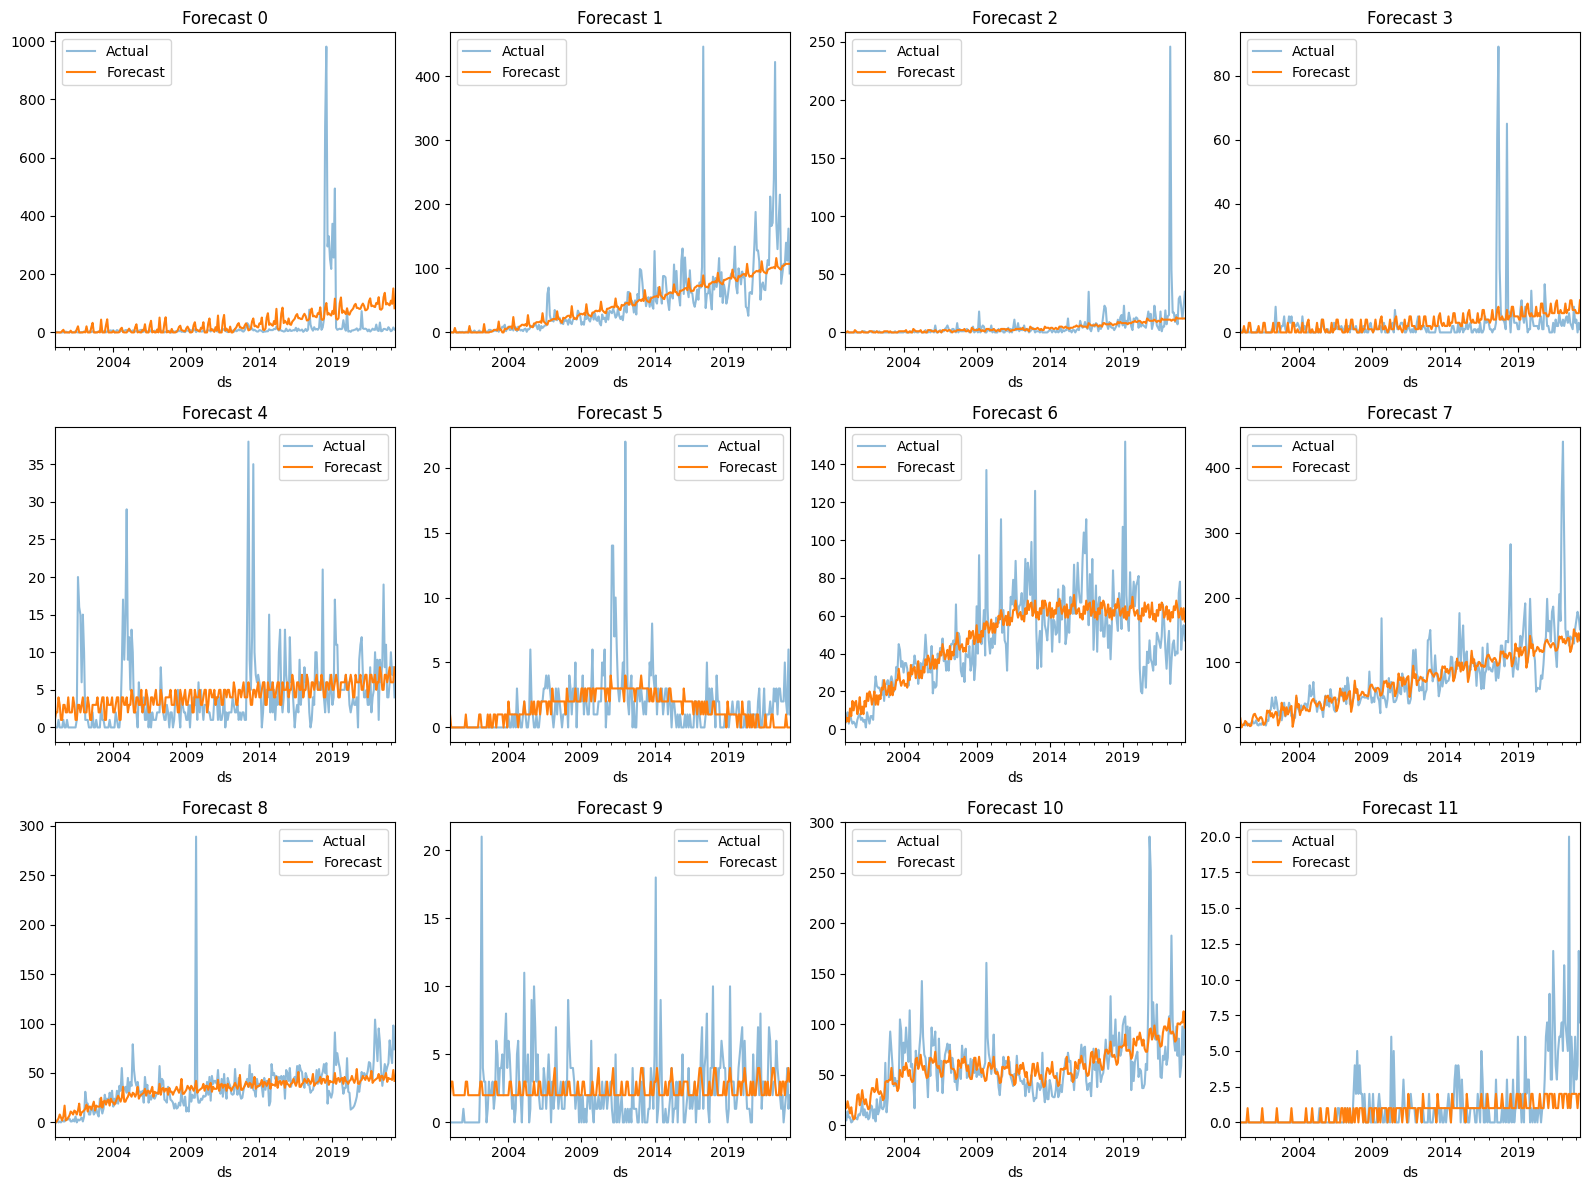

In [25]:
# Plot some forecasts
n = 12
fig,axes = plt.subplots(nrows=3, ncols=4, figsize=(16,12))
axes = axes.flatten()

for i in range(n):
    ytrain = X_train.iloc[:, i]
    y = df.iloc[:, i]
    ypred = fit_forecast(ytrain, test_size, freq='M', include_history=True)
    ax = plot_comparison(y, ypred, axes[i])
    axes[i].set_title(f"Forecast {i}")

plt.tight_layout()
plt.show()